# OMSF 2025 Joint Demo

https://github.com/openforcefield/joint-demo

## Joint demo: High-throughput screening pipeline

Let's build a pipeline for evaluating ligand binding in MCL1.

In [ ]:
%%bash
# run_openfold predict \
#     --use_msa_server \
#     --query_json mcl_query.json \
#     --output_dir ./outputs/

In [ ]:
import nglview


view = nglview.show_file("source/openfold/5fdr.pdb")

view.add_component("source/openfold/5fdr_prediction_aligned.pdb", color="red")
view.update_representation(color="blue")
view.center(1234)

view

### Visualize target protein

Crystal structure of MCL1

In [ ]:
nglview.show_file("source/openfe/protein.pdb")

### Visualize ligand set

Ligand dataset given in SMILES

In [ ]:
import pandas


design_set = pandas.read_csv("source/openadmet/ligands.csv")
design_set.head()

In [ ]:
import datamol


design_set["mol"] = design_set["SMILES"].apply(datamol.to_mol)
datamol.to_image(design_set["mol"])

### Filter ADMET liabilities

Use OpenADMET CLI to predict PIC50 values of different CYPs for each ligand

In [ ]:
!openadmet predict \
    --input-path ./source/openadmet/ligands.csv \
    --input-col SMILES \
    --model-dir ./source/openadmet/cyp3a4_anvil_lgbm \
    --model-dir ./source/openadmet/cyp2d6_anvil_lgbm \
    --model-dir ./source/openadmet/cyp2c9_anvil_lgbm \
    --model-dir ./source/openadmet/cyp1a2_anvil_lgbm \
    --output-path ./predictions.csv &> /dev/null

In [ ]:
predictions = pandas.read_csv("predictions.csv")
predictions.sort_values("OADMET_PRED_openadmet-CYP3A4-pchembl-lgbm", ascending=False)

In [ ]:
CYP3A4_P_IC50_THRESHOLD = 5.6  # IC50 of 2.5 micromolar

mask = predictions["OADMET_PRED_openadmet-CYP3A4-pchembl-lgbm"] < CYP3A4_P_IC50_THRESHOLD

In [ ]:
keep = predictions[mask]
keep

### Run RBFE campaign

Use OpenFE's CLI to prepare, run, and gather free energy calculations


In [ ]:
!cat source/openfe/settings.yaml

In [ ]:
!openfe plan-rbfe-network \
    --protein source/openfe/protein.pdb \
    --molecules source/openfe/ligands_charged.sdf \
    --settings source/openfe/settings.yaml \
    --output-dir rbfe/

In [ ]:
import openfe
from konnektor.visualization import draw_ligand_network

In [ ]:
draw_ligand_network(
    openfe.setup.LigandNetwork.from_graphml(open("rbfe/ligand_network.graphml").read()),
    node_size=3500,
);

In [ ]:
%%bash
# openfe quickrun rbfe/transformations/rbfe_ligand_14_complex_ligand_13_complex.json \
#     -o results_complex.json \
#     -d working-directory/

In [ ]:
!openfe gather source/openfe/results_jsons/

## OpenADMET deep dive

### Compare predictions of different CYP models

In [ ]:
import seaborn
from matplotlib import pyplot


seaborn.histplot(data=predictions, bins=20, alpha=0.3, fill=True)

pyplot.xlabel("predicted pChEMBL")
pyplot.title("Distribution of predicted pChEMBL values for CYP antitargets")

pyplot.show()

In [ ]:
CYP1A2_pChEMBL_data = pandas.read_csv("./source/openadmet/cyp1a2_chembl_permissive.csv")
CYP1A2_pChEMBL_data["target"] = "CYP1A2"
CYP3A4_pChEMBL_data = pandas.read_csv("./source/openadmet/cyp3a4_chembl_permissive.csv")
CYP3A4_pChEMBL_data["target"] = "CYP3A4"
CYP2C9_pChEMBL_data = pandas.read_csv("./source/openadmet/cyp2c9_chembl_permissive.csv")
CYP2C9_pChEMBL_data["target"] = "CYP2C9"
CYP2D6_pChEMBL_data = pandas.read_csv("./source/openadmet/cyp2d6_chembl_permissive.csv")
CYP2D6_pChEMBL_data["target"] = "CYP2D6"

combined = pandas.concat(
    [
        CYP2D6_pChEMBL_data,
        CYP2C9_pChEMBL_data,
        CYP1A2_pChEMBL_data,
        CYP3A4_pChEMBL_data,
    ]
)

In [ ]:
seaborn.kdeplot(combined, x="pchembl_value_mean", hue="target")

pyplot.title("Distribution of CYP pChEMBL values (ChEMBL 35)")
pyplot.xlabel("Target pChEMBL")

pyplot.show()

## OpenFE deep dive

More OpenFE CLI features

[CLI reference](https://docs.openfree.energy/en/stable/reference/cli/index.html)

### Charge molecules ahead of time

In [ ]:
!openfe charge-molecules \
    --molecules source/openfe/ligands.sdf \
    --output out.sdf \
    --n-cores 10

In [ ]:
!cat source/openfe/nagl.yaml

In [ ]:
!openfe charge-molecules \
    --molecules source/openfe/ligands.sdf \
    --output ligands_nagl.sdf \
    --settings source/openfe/nagl.yaml \
    --n-cores 1

### Use different ligand networks

In [ ]:
%%html
<img src="source/openfe/network_layouts.png">

In [ ]:
!cat source/openfe/radial.yaml

In [ ]:
!openfe plan-rbfe-network \
    --protein source/openfe/protein.pdb \
    --molecules source/openfe/ligands_charged.sdf \
    --settings source/openfe/radial.yaml \
    --output-dir radial

In [ ]:
draw_ligand_network(
    openfe.setup.LigandNetwork.from_graphml(open('radial/ligand_network.graphml').read()),
    node_size=3500);

## OpenFF deep dive

### RDKit to MD simulation in seconds

In [ ]:
from openff.toolkit import Molecule
from rdkit import Chem


rdmol = Chem.MolFromMolFile("source/openff/aspirin.sdf")

molecule = Molecule.from_rdkit(rdmol)
molecule.visualize(backend="rdkit")

In [ ]:
from openff.toolkit import ForceField

from simulate import simulate_and_visualize


sage = ForceField("openff-2.2.1.offxml")

simulate_and_visualize(rdmol, sage)

### Protein-ligand complexes with Sage + ff14SB

In [ ]:
from openff.toolkit import Molecule, Topology


topology = Topology.from_pdb(
    "source/openff/complex_topology.pdb",
    unique_molecules=[Molecule.from_smiles("c12c(Cl)cccc1sc(C(=O)[O-])c(Cl)2")],
)

ligand = topology.molecule(1)

topology.visualize()

In [ ]:
import openmm.unit
from pdbfixer import PDBFixer


fixer = PDBFixer("source/openff/complex_topology.pdb")

fixer.addSolvent(
    padding=1.0 * openmm.unit.nanometer,
    ionicStrength=0.15 * openmm.unit.molar,
)

with open("receptor_solvated.pdb", "w") as f:
    openmm.app.PDBFile.writeFile(fixer.topology, fixer.positions, f)

solvated_topology = Topology.from_pdb(
    "receptor_solvated.pdb",
    unique_molecules=[ligand],
)

solvated_topology.set_positions(
    solvated_topology.get_positions() - solvated_topology.get_positions().min(axis=0)
)
solvated_topology.visualize()

In [ ]:
import pathlib

from openff.interchange import Interchange


if not pathlib.Path("interchange.json").exists():
    sage_with_ff14sb = ForceField(
        "openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml"
    )

    interchange = sage_with_ff14sb.create_interchange(solvated_topology)

    with open("interchange.json", "w") as f:
        f.write(interchange.json())

interchange = Interchange.model_validate_json(open("interchange.json").read())

In [ ]:
from simulate import run_openmm_half_minute


run_openmm_half_minute(interchange, "protein-ligand.dcd")

In [ ]:
import mdtraj


nglview.show_mdtraj(
    mdtraj.load(
        "protein-ligand.dcd",
        top=mdtraj.Topology.from_openmm(solvated_topology.to_openmm()),
    )
)

### Post-translational modifications

Taken from OpenFF's prototype PTM workflow:

https://github.com/openforcefield/ptm_prototype

What about non-canonical amino acids, or other molecules covalently bound to a protein?

In [ ]:
from openff.toolkit import Molecule


dye = Molecule.from_file("source/openff/maleimide.sdf")
dye.generate_unique_atom_names()
dye

In [ ]:
from ipywidgets import Image
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts


thiol_maleimide_click_smarts = (
    "[C:10]-[S:1]-[H:2]"
    + "."
    + "[N:3]1-[C:4](=[O:5])-[C:6](-[H:11])=[C:7](-[H:12])-[C:8](=[O:9])-1"
    + ">>"
    + "[N:3]1-[C:4](=[O:5])-[C:6](-[H:2])(-[H:11])-[C@:7](-[S:1]-[C:10])(-[H:12])-[C:8](=[O:9])-1"
)

d2d = Draw.MolDraw2DCairo(800, 300)
d2d.DrawReaction(
    ReactionFromSmarts(thiol_maleimide_click_smarts),
    highlightByReactant=True,
)
Image(value=d2d.GetDrawingText())

In [ ]:
from openff.pablo import (
    CCD_RESIDUE_DEFINITION_CACHE,
    ResidueDefinition,
    topology_from_pdb,
)
from openff.pablo.chem import PEPTIDE_BOND

from ptm_prototype import react


cysteine = CCD_RESIDUE_DEFINITION_CACHE["CYS"][0].to_openff_molecule()

products = list(react([cysteine, dye], thiol_maleimide_click_smarts))
cysteine_with_dye = products[0][0]
name_corrections = {
    4: "H3x",
    25: "C9x",
    26: "H4x",
    28: "C8x",
    29: "H6x",
    30: "H5x",
    32: "C10x",
    33: "C11x",
    34: "O2x",
    35: "O3x",
    36: "C23x",
    37: "C12x",
    38: "C22x",
    39: "C18x",
    40: "C13x",
    41: "C17x",
    42: "H14x",
    43: "C21x",
    44: "C19x",
    45: "O5x",
    46: "C14x",
    47: "H7x",
    49: "H13x",
    50: "C20x",
    51: "H11x",
    52: "C15x",
    53: "H8x",
    54: "H10x",
    55: "O6x",
}
for i, name in name_corrections.items():
    cysteine_with_dye.atom(i).name = name

cysteine_with_dye.visualize(backend="rdkit")

In [ ]:
dye_resdef = ResidueDefinition.from_molecule(
    molecule=cysteine_with_dye,
    residue_name="DYE",
    linking_bond=PEPTIDE_BOND,
)

topology = topology_from_pdb(
    "source/openff/3ip9_dye_solv.pdb",
    residue_database=CCD_RESIDUE_DEFINITION_CACHE.with_({"DYE": [dye_resdef]}),
)
view = topology.visualize()
view.clear_representations()
view.add_cartoon()
view.add_line(opacity=0.5, crossSize=1.0)
view.add_licorice("DYE", radius=0.3)
view.add_unitcell()
view.center("DYE")
view

In [ ]:
from ptm_prototype import parametrize_with_nagl, simulate_and_visualize


if not pathlib.Path("ptm.dcd").exists():
    sage_ff14sb = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml")
    interchange = parametrize_with_nagl(force_field=sage_ff14sb, topology=topology)

    simulate_and_visualize(interchange)

In [ ]:
import mdtraj
import nglview


trajectory: mdtraj.Trajectory = mdtraj.load(
    "ptm.dcd", top=mdtraj.Topology.from_openmm(topology.to_openmm())
)

view = nglview.show_mdtraj(trajectory)

view.clear_representations()
view.add_cartoon()
view.add_line(opacity=0.5, crossSize=1.0)
view.add_licorice("DYE", radius=0.3)
view.add_unitcell()
view.center("DYE")
view

### NAGL assigns charges quickly

In [5]:
from openff.toolkit.utils.ambertools_wrapper import AmberToolsToolkitWrapper
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper

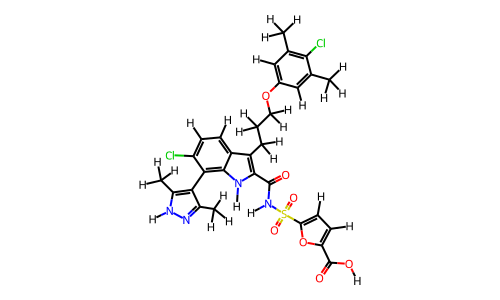

In [6]:
ambertools_wrapper = AmberToolsToolkitWrapper()

nagl_wrapper = NAGLToolkitWrapper()
nagl_wrapper.assign_partial_charges(
    Molecule.from_smiles("C"),
    "openff-gnn-am1bcc-0.1.0-rc.3.pt",
)

ligand_5x3 = Molecule.from_smiles(
    "Cc1cc(cc(c1Cl)C)OCCCc2c3ccc(c(c3[nH]c2C(=O)NS(=O)(=O)c4ccc(o4)C(=O)O)c5c([nH]nc5C)C)Cl"
)
ligand_5x3

In [ ]:
# %%timeit
# ambertools_wrapper.assign_partial_charges(ligand_5x3)
#
# 3min 20s ± 2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
%%timeit
nagl_wrapper.assign_partial_charges(ligand_5x3, "openff-gnn-am1bcc-0.1.0-rc.3.pt");

## Credits

* Zachary Baker (OMSF)
* Mallory Tollefson, Jennifer Wei, OpenFold team
* Hugo MacDermott-Opeskin, Ryan Renslow, OpenADMET team
* Irfan Alibay, Alyssa Travitz, OpenFE team
* Jeff Wagner, Josh Mithell, OpenFF team